In [266]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

from sklearn.feature_selection import VarianceThreshold

In [267]:
df_train = pd.read_csv(r"C:\Users\21109\Desktop\Molecule_prediction_20200312\Molecule_prediction_20200312\train_0312.csv")
df_test = pd.read_csv(r"C:\Users\21109\Desktop\Molecule_prediction_20200312\Molecule_prediction_20200312\test_noLabel_0312.csv")
df_sub =pd.read_csv(r"C:\Users\21109\Desktop\Molecule_prediction_20200312\Molecule_prediction_20200312\submit_examp_0312.csv")

In [268]:
#合并训练数据和测试数据，重新编排索引
df = pd.concat([df_train, df_test], sort=False)
df.index= [i for i in range(len(df))]
df

,ID,Molecule_max_phase,Molecular weight,RO5_violations,AlogP,Features,Label
0,train_0,0,0.153946,0.0,0.691234,"[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 9, 1, 0, 0, ...",9.441452
1,train_1,0,0.215663,0.0,0.682300,"[0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 8, 4, 0, 0,...",13.146080
2,train_2,0,0.264946,2.0,0.781686,"[0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 8, 0, 0, 1, ...",10.085809
3,train_3,4,0.106954,0.0,0.556114,"[0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, ...",-2.995732
4,train_4,4,0.098934,0.0,0.651591,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 9, 1, 0, 0, ...",0.470004
...,...,...,...,...,...,...,...
8650,test_1726,0,0.174494,0.0,0.736460,"[0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 7, 1, 0, 1, ...",NaN
8651,test_1727,0,0.170864,0.0,0.710776,"[0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 8, 2, 0, 0, ...",NaN
8652,test_1728,0,0.246219,1.0,0.753210,"[0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 10, 3, 0, 0,...",NaN
8653,test_1729,0,0.182304,0.0,0.600782,"[0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 8, 2, 0, 0, ...",NaN


In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8655 entries, 0 to 8654
Data columns (total 7 columns):
ID                    8655 non-null object
Molecule_max_phase    8655 non-null int64
Molecular weight      8655 non-null float64
RO5_violations        8561 non-null float64
AlogP                 8561 non-null float64
Features              8655 non-null object
Label                 6924 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 540.9+ KB


In [270]:
from sklearn.ensemble import RandomForestRegressor

#选择训练特征数据来预测RO5_violations补充缺失RO5_violations
RO5_df = df[['RO5_violations','Molecule_max_phase','Molecular weight',]]
RO5_df_notnull = RO5_df.loc[(df['RO5_violations'].notnull())]   #先去掉年RO5_violations为空的数据
RO5_df_isnull = RO5_df.loc[(df['RO5_violations'].isnull())]
X = RO5_df_notnull.values[:,1:]   
Y = RO5_df_notnull.values[:,:1]
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictRO5 = RFR.predict(RO5_df_isnull.values[:,1:])
df.loc[df['RO5_violations'].isnull(), ['RO5_violations']]= predictRO5

In [271]:
#选择训练特征数据来预测AlogP补充缺失AlogP
AlogP_df = df[['AlogP','Molecule_max_phase','Molecular weight',]]
AlogP_df_notnull = AlogP_df.loc[(df['AlogP'].notnull())]   #先去掉年AlogP为空的数据
AlogP_df_isnull = AlogP_df.loc[(df['AlogP'].isnull())]
X = AlogP_df_notnull.values[:,1:]   
Y = AlogP_df_notnull.values[:,:1]
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAlogP = RFR.predict(AlogP_df_isnull.values[:,1:])
df.loc[df['AlogP'].isnull(), ['AlogP']]= predictAlogP

In [272]:
#分子重量和脂分配系数有少数几个为零，根据分析，应该不可能，将其补值为除零的最小数
second1 = df['Molecular weight'].sort_values(ascending = True).unique()[1]  #对'Molecular weight’排序，取第二小数
df.loc[(df['Molecular weight']==0),'Molecular weight'] = second1

second2 = df['AlogP'].sort_values(ascending = True).unique()[1]  #对'AlogP’排序，取第二小数
df.loc[(df['AlogP']==0),'AlogP'] = second2

In [273]:
#将Features列中向量分割开来

df_feature = df.Features.values
df_feature = np.array(df_feature)
new_feature = []
df_feature 
for line in df_feature:
    line = line[1:-1]
    arra = line.split(',')
    arra = np.array(arra).astype(np.float64)
    new_feature.append(arra)

new_feature = np.array(new_feature)
df1 = pd.DataFrame(new_feature,columns=(['f'+ str(i) for i in range(3168)]))  #将分开向量合成数据框类型

In [274]:
#新增四列统计列，最小值，最大值，平均数，总和，推测可能有利于模型
df1['f_min'] = [i.min() for i in new_feature]
df1['f_max'] = [i.max() for i in new_feature]
df1['f_mean'] = [i.mean() for i in new_feature]
df1['f_sum'] = [i.sum() for i in new_feature]

In [275]:
#统计每个向量中0所占比率
df_zero = []
for i in range(len(df)):
    j = (df1.loc[i,'f0':'f3167']==0).sum()
    df_zero.append(j/len(df1))
df1['zero'] = df_zero

In [276]:
#统计每个向量中1所占比率
df_one = []
for i in range(len(df)):
    j = (df1.loc[i,'f0':'f3167']==1).sum()
    df_one.append(j/len(df1))
df1['one'] = df_one

In [277]:
 #检查 df1 有无空值,发现5093行有空值
df1[(df1.isnull().T.any())] 

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f3164,f3165,f3166,f3167,f_min,f_max,f_mean,f_sum,zero,one
5093,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,...,6.0,0.0,54.26,4.0,NaN,NaN,NaN,NaN,0.335413,0.027961


In [278]:
df1.loc[5092:,'f3152':'f3164']

,f3152,f3153,f3154,f3155,f3156,f3157,f3158,f3159,f3160,f3161,f3162,f3163,f3164
5092,1.062500,1.812500,2.500000,249.040,0.381706,0.241599,0.241599,-0.381706,0.0,82.0,256.096,2.00980,5.0
5093,1.088235,1.852941,2.470588,510.252,NaN,NaN,NaN,NaN,0.0,176.0,532.428,3.66380,6.0
5094,0.850000,1.466667,2.083333,802.656,0.390871,0.252881,0.252881,-0.390871,0.0,320.0,858.096,5.15390,13.0
5095,1.128205,1.846154,2.512821,524.389,0.479925,0.322713,0.322713,-0.479925,0.0,210.0,558.661,0.67407,12.0
5096,1.281250,2.062500,2.781250,413.279,0.496622,0.220850,0.220850,-0.496622,0.0,172.0,443.519,2.96850,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8650,1.206897,1.965517,2.689655,371.266,0.440632,0.414538,0.414538,-0.440632,0.0,146.0,390.418,4.62688,6.0
8651,1.222222,2.000000,2.777778,361.707,0.340642,0.318953,0.318953,-0.340642,0.0,140.0,383.883,4.17330,6.0
8652,1.000000,1.710526,2.394737,484.360,0.382090,0.272592,0.272592,-0.382090,0.0,200.0,519.640,4.92570,6.0
8653,1.178571,1.857143,2.464286,380.300,0.372823,0.319003,0.319003,-0.372823,0.0,150.0,404.492,2.20120,8.0


In [279]:
#对空值进行补值
#对f3156-f3159列进行局部平均数补值
def ployinterp_column(s, n, k=5):
  y = s[list(range(n-k, n)) + list(range(n+1, n+1+k))]      #当n=7时，取数y=s[2，3，4，5，6，8，9，10，11，12]
  y = y[y.notnull()]    #剔除空值
  return y.mean()     #插值并返回插值结果

#逐个元素判断是否需要补值
for i in ('f3156','f3157','f3158','f3159','f_min','f_max','f_mean','f_sum'):
    j = 5093
    #if (df1[i].isnull())[j]: #如果为空即插值。
    df1[i][j] = ployinterp_column(df1[i], j)

In [280]:
#将向量拆分列和原来数据合并
#为了使标签列在最后，选择先删掉标签列再添加
#删除无用原有Featrues，ID列，最终得到df4
df2 = df[['Label']]
df3 = df.drop(['Label'],axis = 1)
df4 = df3.join(df1)
df4 = df4.drop(['Features','ID'],axis = 1)#删除没有标签
df4 = df4.join(df2)

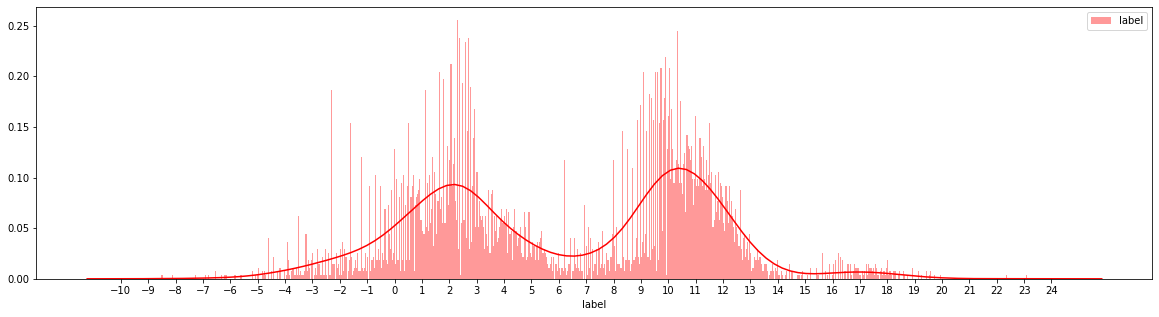

In [256]:
#绘制label分布图（可看出label列以6.5为界呈双峰图，推断Label为两大种小分子物质）
plt.figure(figsize=(20,5))
sns.distplot(df['Label'],color='r',label='label',bins=800,hist=True, kde=True)
plt.xticks([i for i in range(-10,25)])
plt.xlabel('label')
plt.legend()
plt.show()

In [281]:
#标注上述的二分类label,命名为new_label
def biaozhu(x):
    if x<6.5:
        y=0
    else:
        y=1
    return y
new_Label=df_train['Label'].map(biaozhu)

In [282]:
#过滤没有变化的特征
selectcolumn = (df4.max(axis=0) != df4.min(axis=0))
selectcolumn = np.array(selectcolumn)
df5= df4.loc[:,selectcolumn]
df5

,Molecule_max_phase,Molecular weight,RO5_violations,AlogP,f4,f6,f7,f8,f9,f10,...,f3165,f3166,f3167,f_min,f_max,f_mean,f_sum,zero,one,Label
0,0,0.153946,0.0,0.691234,0.0,3.0,0.0,0.0,0.0,0.0,...,1.0,56.15,5.0,-0.494533,353.397,0.463077,1467.029385,0.340959,0.022992,9.441452
1,0,0.215663,0.0,0.682300,0.0,0.0,0.0,10.0,0.0,0.0,...,1.0,65.54,7.0,-0.349011,464.585,0.599497,1899.205097,0.335760,0.027730,13.146080
2,0,0.264946,2.0,0.781686,0.0,0.0,0.0,3.0,0.0,0.0,...,2.0,87.28,7.0,-0.405788,553.381,0.706570,2238.415258,0.334951,0.028538,10.085809
3,4,0.106954,0.0,0.556114,0.0,0.0,0.0,6.0,0.0,0.0,...,1.0,41.57,4.0,-0.378793,268.744,0.346830,1098.756838,0.347429,0.016522,-2.995732
4,4,0.098934,0.0,0.651591,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,54.37,4.0,-0.480788,254.285,0.330614,1047.385208,0.350318,0.013518,0.470004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8650,0,0.174494,0.0,0.736460,0.0,0.0,0.0,5.0,0.0,0.0,...,1.0,82.01,2.0,-0.440632,390.418,0.520884,1650.161229,0.336915,0.026921,NaN
8651,0,0.170864,0.0,0.710776,0.0,1.0,0.0,3.0,0.0,0.0,...,3.0,73.05,3.0,-0.340642,383.883,0.506503,1604.602493,0.338070,0.025419,NaN
8652,0,0.246219,1.0,0.753210,0.0,2.0,0.0,7.0,0.0,0.0,...,2.0,60.50,6.0,-0.382090,519.640,0.662992,2100.357115,0.333564,0.029809,NaN
8653,0,0.182304,0.0,0.600782,0.0,2.0,0.0,3.0,0.0,0.0,...,2.0,100.63,5.0,-0.372823,404.492,0.533432,1689.913033,0.339804,0.023570,NaN


In [284]:
#拆分训练集和测试集准备建立模型
df_test1 = df5[df5['Label'].isnull()].copy()
df_train1 = df5[df5['Label'].notnull()].copy()
df_train2 = df_train1.drop(['Label'],axis = 1)
df_test2 = df_test1.drop(['Label'],axis = 1)

In [285]:
#选择lgbm模型进行二分类预测分析
#进行十则交叉验证
def lgb_class_train(pout_train,test_df,target):
    folds=KFold(n_splits=10, shuffle=True, random_state=666)
    oof=np.zeros(len(pout_train))
    feature_importance_df=pd.DataFrame()
    predictions=np.zeros(len(test_df))
    
    for fold_, (trn_idx, val_idx)  in enumerate(folds.split(pout_train.values,target)):
        print("Fold {}".format(fold_))
        gbm = LGBMRegressor(objective='binary', num_leaves=31, learning_rate=0.05, n_estimators=1500)
        gbm.fit(pout_train.values[trn_idx], target[trn_idx], eval_set=[(pout_train.values[val_idx], target[val_idx])], eval_metric='l1',verbose=200, early_stopping_rounds=300)
        
        oof[val_idx]=gbm.predict(pout_train.values[val_idx],num_iteration=gbm.best_iteration_)
        predictions+=gbm.predict(test_df.values,num_iteration=gbm.best_iteration_)/folds.n_splits
        fold_importance_df=pd.DataFrame()
        fold_importance_df["Feature"]=pout_train.columns
        fold_importance_df["importance"]=gbm.feature_importances_
        fold_importance_df["fold"]=fold_+1
        feature_importance_df=pd.concat([feature_importance_df, fold_importance_df],axis=0)
    print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

    cols=(feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:150].index)
    best_features=feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    plt.figure(figsize=(14,30))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.show()
    return oof,predictions

Fold 0
Training until validation scores don't improve for 300 rounds
[200]	valid_0's l1: 0.129936	valid_0's binary_logloss: 0.19907
[400]	valid_0's l1: 0.0906774	valid_0's binary_logloss: 0.174247
[600]	valid_0's l1: 0.0774321	valid_0's binary_logloss: 0.17876
Early stopping, best iteration is:
[396]	valid_0's l1: 0.0909411	valid_0's binary_logloss: 0.173703
Fold 1
Training until validation scores don't improve for 300 rounds
[200]	valid_0's l1: 0.129287	valid_0's binary_logloss: 0.189971
[400]	valid_0's l1: 0.0891979	valid_0's binary_logloss: 0.166018
[600]	valid_0's l1: 0.0755813	valid_0's binary_logloss: 0.174883
Early stopping, best iteration is:
[400]	valid_0's l1: 0.0891979	valid_0's binary_logloss: 0.166018
Fold 2
Training until validation scores don't improve for 300 rounds
[200]	valid_0's l1: 0.129633	valid_0's binary_logloss: 0.201394
[400]	valid_0's l1: 0.0917898	valid_0's binary_logloss: 0.179673
[600]	valid_0's l1: 0.0792645	valid_0's binary_logloss: 0.189503
Early stoppin

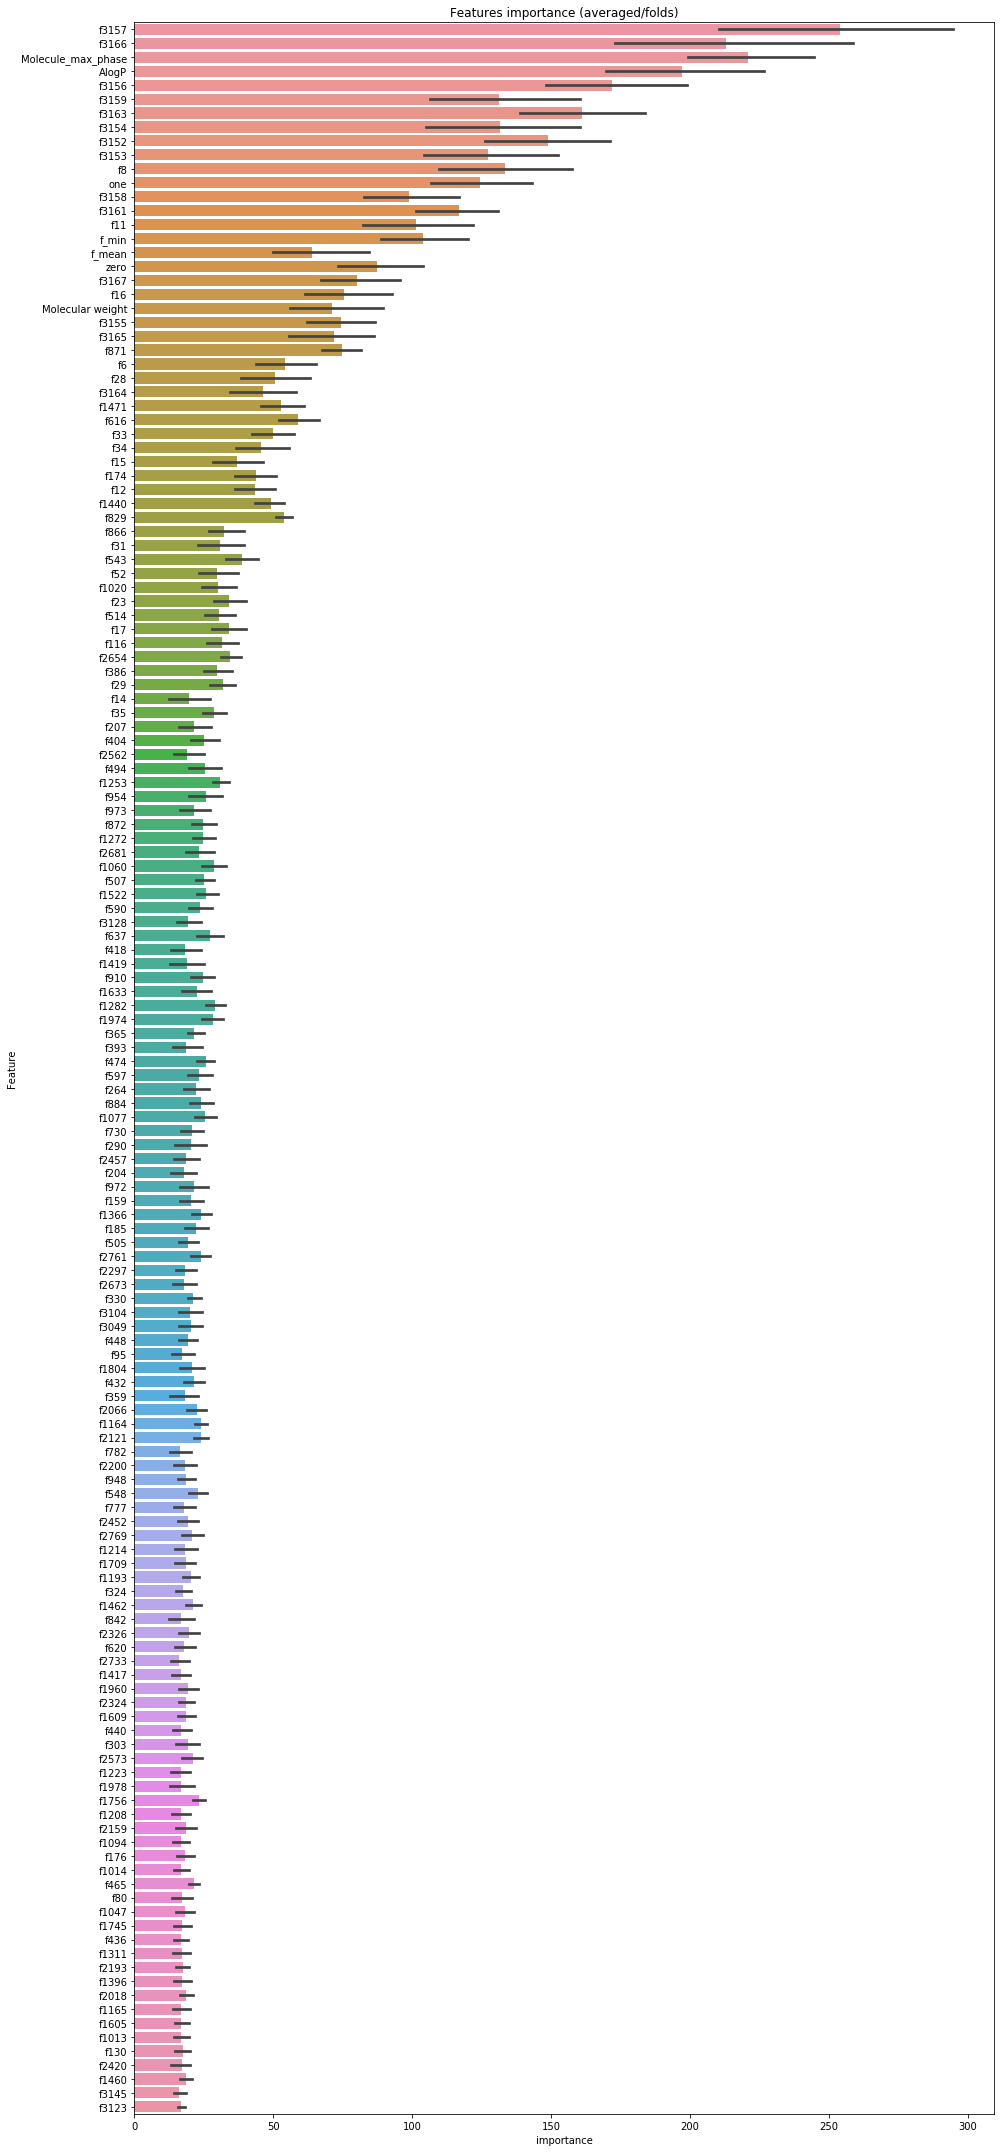

In [286]:
#利用数据来源俩个不同的分布的特点进行训练
train_oof,test_pre=lgb_class_train(df_train2,df_test2,new_Label)

In [287]:
#将数据属于new_label类别1的概率作为新的特征
df_train2['sign']=train_oof
df_test2['sign']=test_pre

In [288]:
#计算rmse
def calc_rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

In [289]:
def lgb_train(pout_train,test_df,target):
    folds=KFold(n_splits=10, shuffle=True, random_state=666)
    oof=np.zeros(len(pout_train))
    feature_importance_df=pd.DataFrame()
    predictions=np.zeros(len(test_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(pout_train.values,target)):
        print("Fold {}".format(fold_))
        gbm = LGBMRegressor(objective='regression', num_leaves=31, learning_rate = 0.01, n_estimators=1500)
        gbm.fit(pout_train.values[trn_idx], target[trn_idx], eval_set=[(pout_train.values[val_idx], target[val_idx])], eval_metric='l1',verbose=200, early_stopping_rounds=300)
        
        oof[val_idx]=gbm.predict(pout_train.values[val_idx],num_iteration=gbm.best_iteration_)
        predictions+=gbm.predict(test_df.values,num_iteration=gbm.best_iteration_)/folds.n_splits
        fold_importance_df=pd.DataFrame()
        fold_importance_df["Feature"]=pout_train.columns
        fold_importance_df["importance"]=gbm.feature_importances_
        fold_importance_df["fold"]=fold_+1
        feature_importance_df=pd.concat([feature_importance_df, fold_importance_df],axis=0)
    print("CV score: {:<8.8f}".format(calc_rmse(oof,target.values)))
    
    #保存结果
    
    df_sub['Label']=predictions
    df_sub.to_csv(r"C:\Users\21109\Desktop\Molecule_prediction_20200312\Molecule_prediction_20200312\Result_lgb2.csv",index=False)
    
    cols=(feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:150].index)
    best_features=feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    plt.figure(figsize=(14,30))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.show()
    return feature_importance_df

Fold 0
Training until validation scores don't improve for 300 rounds
[200]	valid_0's l1: 1.51275	valid_0's l2: 4.6828
[400]	valid_0's l1: 1.37225	valid_0's l2: 4.17486
[600]	valid_0's l1: 1.32363	valid_0's l2: 4.05629
[800]	valid_0's l1: 1.30003	valid_0's l2: 4.02816
[1000]	valid_0's l1: 1.28748	valid_0's l2: 4.00159
[1200]	valid_0's l1: 1.27669	valid_0's l2: 3.98555
[1400]	valid_0's l1: 1.26924	valid_0's l2: 3.98263
Did not meet early stopping. Best iteration is:
[1494]	valid_0's l1: 1.26577	valid_0's l2: 3.98754
Fold 1
Training until validation scores don't improve for 300 rounds
[200]	valid_0's l1: 1.6741	valid_0's l2: 6.06479
[400]	valid_0's l1: 1.50839	valid_0's l2: 5.43134
[600]	valid_0's l1: 1.47133	valid_0's l2: 5.32469
[800]	valid_0's l1: 1.44801	valid_0's l2: 5.26284
[1000]	valid_0's l1: 1.43339	valid_0's l2: 5.22371
[1200]	valid_0's l1: 1.42127	valid_0's l2: 5.19801
[1400]	valid_0's l1: 1.41233	valid_0's l2: 5.16764
Did not meet early stopping. Best iteration is:
[1497]	vali

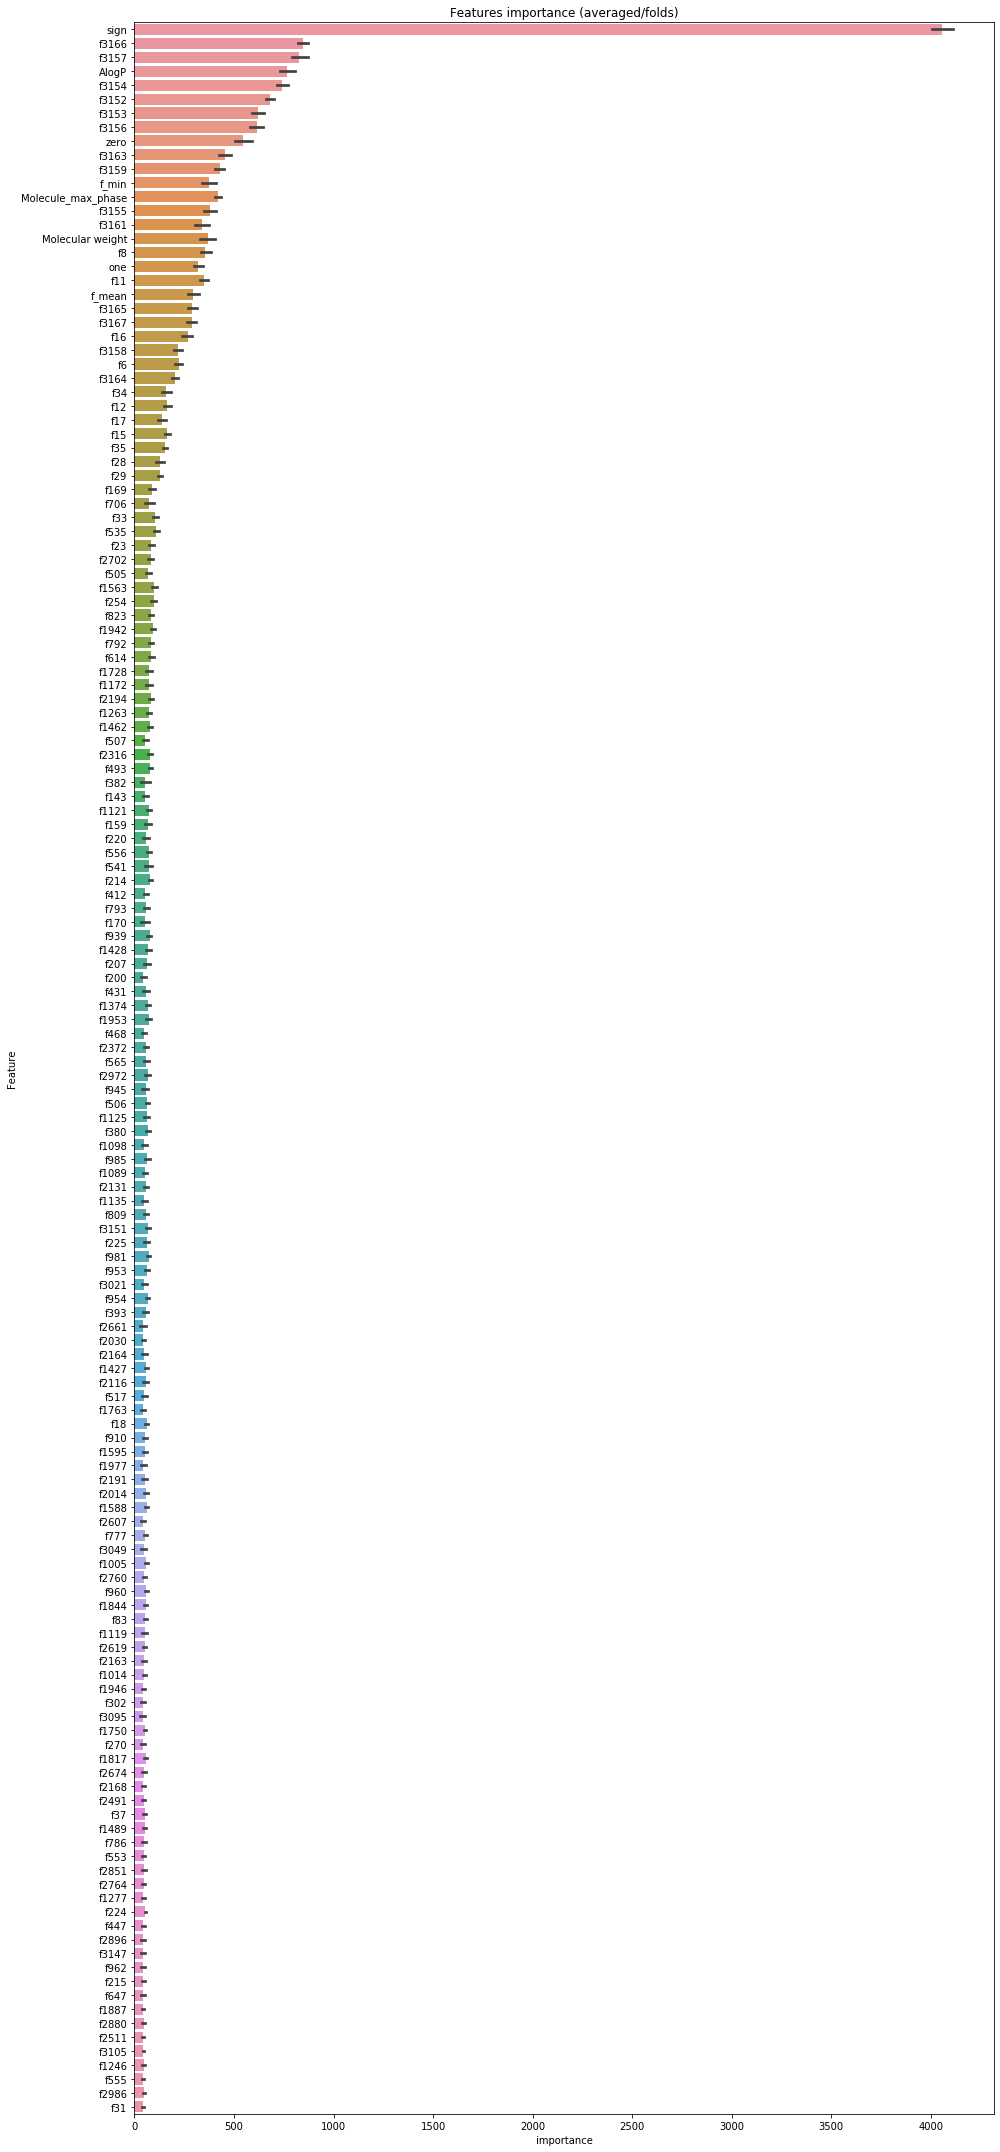

In [290]:
#进行训练，结果保存在'work/Result_lgb2.csv'中
df=lgb_train(df_train2, df_test2,df_train['Label'])